In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import*
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,precision_score,recall_score,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [2]:
df= pd.read_csv("aug_train.csv")

In [3]:
df.head(8)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
5,21651,city_176,0.764,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1,24,1.0
6,28806,city_160,0.920,Male,Has relevent experience,no_enrollment,High School,NaN,5,50-99,Funded Startup,1,24,0.0
7,402,city_46,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1.0


In [4]:
df.columns.tolist()

['enrollee_id',
 'city',
 'city_development_index',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job',
 'training_hours',
 'target']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

# creating a prerocessing funtinon

In [6]:
# full preprocessing in a singel function that can handle null , outliers , skewness , inbalance in data and feature engiering for categorical data 

from imblearn.over_sampling import SMOTENC
import pandas as pd
import numpy as np

class Preprocessing:
    def __init__(self, df):
        self.df = df
        self.imputed_df = None
        self.balance_df = None
        self.featureEncoded_df = None
        self.target_mean_feature = []
        self.categorical_features_indices = []

    def handle_nulls(self):
        """Fill null values in specific columns."""
        self.df["enrolled_university"] = self.df["enrolled_university"].fillna("none")
        self.df["education_level"] = self.df["education_level"].fillna("Other")

        # Fill nulls in 'experience' with mode and ensure it's treated as numeric
        mode = self.df["experience"].mode()[0]
        self.df["experience"] = self.df["experience"].fillna(mode)  # Ensure it's float

        self.df["last_new_job"] = self.df["last_new_job"].fillna("Not Specified")
        self.df['major_discipline'] = self.df['major_discipline'].fillna("Not_Specified")
        self.df["gender"] = self.df["gender"].fillna("Not_specified")
        self.df["company_size"] = self.df["company_size"].fillna("NS")
        self.df["company_type"] = self.df["company_type"].fillna("not_specified")
        self.imputed_df = self.df
        return self.df

    def encode_features(self):
        # Encode categorical features with target mean.
        features = ['gender', "enrolled_university", "major_discipline",
                    "education_level", "company_type", "city"]

        for i, feature in enumerate(features):
            self.target_mean_feature.append(self.df.groupby(feature)['target'].mean())
            self.df[feature] = self.df[feature].map(self.target_mean_feature[i])

        rel_exp={'Has relevent experience':1,'No relevent experience':0}
        # Map relevant experience to binary values.
        self.df["relevent_experience"] = self.df["relevent_experience"].map(rel_exp)

        # Map company size categories to numerical values using map().
        size_mapping = {'NS':1,'<10': 2,'10/49': 3,'50-99': 4,'100-500': 5,'500-999': 6,'1000-4999': 7,'5000-9999': 8,'10000+': 9}
        self.df["company_size"]=self.df["company_size"].map(size_mapping)


        # Map last new job categories to numerical values.

        u=df["last_new_job"].unique().tolist()
        un=[2,6,0,5,4,3,1]

        for i,j in zip(u,un):
          self.df["last_new_job"]=self.df["last_new_job"].replace(i,j)


        # Map experience categories to numerical values.

        experience_mapping = {'<1': 0,'1': 1,'2': 2,'3': 3,'4': 4,\
                              '5': 5,'6': 6,'7': 7,'8': 8,'9': 9,\
                              '10': 10,'11': 11,'12': 12,'13': 13,\
                              '14': 14,'15': 15,'16': 16,'17': 17,\
                              '18': 18,'19': 19,'20': 20,'>20': 21,}
        for i,j in zip(experience_mapping.keys(),experience_mapping.values()):
          self.df["experience"]=self.df["experience"].replace(i,j)

        self.featureEncoded_df = self.df
        return self.df



    def handle_outliers(self, features):
         # Handle outliers by capping them for specified features.
        for feature in features:
            Q1 = self.df[feature].quantile(0.25)
            Q3 = self.df[feature].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Cap the outliers
            self.df[feature] = np.where(self.df[feature] > upper_bound, upper_bound,
                                         np.where(self.df[feature] < lower_bound, lower_bound, 
                                                  self.df[feature]))
        
        print("Outliers have been capped.")
        
        return self.df   # Return the modified DataFrame

    def handle_skewness(self, features):
        """Handle skewness using log transformation if necessary."""
        for feature in features:
            skewness_value = self.df[feature].skew()
            if skewness_value > 0.5:  
                # Apply log transformation to reduce skewness
                self.df[feature] = np.log(self.df[feature] + 1)  
        
        print("Skewness has been handled using log transformation where applicable.")
        
        return self.df   # Return the modified DataFrame

    def handle_imbalance(self):
        """Balance the dataset using SMOTENC."""
        X = self.df.drop("target", axis=1)
        y = self.df["target"]

        categorical_features_indices = [self.df.columns.get_loc(col) for col in['city', 'gender','relevent_experience',\
                                                                                'enrolled_university','education_level',\
                                                                                'major_discipline', 'experience',\
                                                                                'company_size', 'company_type',\
                                                                                'last_new_job']]

        smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=42)

        X_resampled, y_resampled = smote_nc.fit_resample(X, y)

        # Concatenate the resampled data back into a DataFrame
        self.balance_df = pd.concat([X_resampled, y_resampled], axis=1)

        # Store the balanced DataFrame back into self.df
        self.df = self.balance_df
        return self.balance_df

    def preprocess(self):
        """Run all preprocessing steps."""       
        
        self.handle_nulls()
        self.handle_imbalance()
        self.encode_features()
        # Handle outliers and skewness
        self.handle_outliers(['training_hours', 'last_new_job', 'city_development_index'])
        # self.handle_skewness(feature_list)
        
        
        
        return self.df   # Return processed DataFrame after encoding and balancing

# EDA

In [7]:
eda = df.copy()
eda

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


In [8]:
eda.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [9]:
# handling null for EDA 
pre=Preprocessing(eda)
eda = pre.handle_nulls()

In [10]:
eda

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NS,not_specified,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,Not_specified,No relevent experience,Full time course,Graduate,STEM,5,NS,not_specified,never,83,0.0
3,33241,city_115,0.789,Not_specified,No relevent experience,none,Graduate,Business Degree,<1,NS,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NS,not_specified,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NS,not_specified,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,Not_Specified,<1,500-999,Pvt Ltd,2,97,0.0


In [11]:
eda.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [12]:
eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  19158 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     19158 non-null  object 
 6   education_level         19158 non-null  object 
 7   major_discipline        19158 non-null  object 
 8   experience              19158 non-null  object 
 9   company_size            19158 non-null  object 
 10  company_type            19158 non-null  object 
 11  last_new_job            19158 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

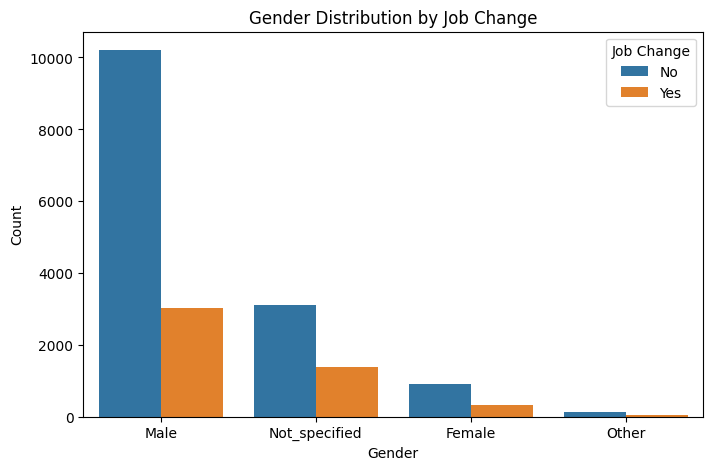

In [13]:
# 1. Gender Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='gender', hue='target', data=eda)
plt.title('Gender Distribution by Job Change')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Job Change', loc='upper right', labels=['No', 'Yes'])
plt.show()

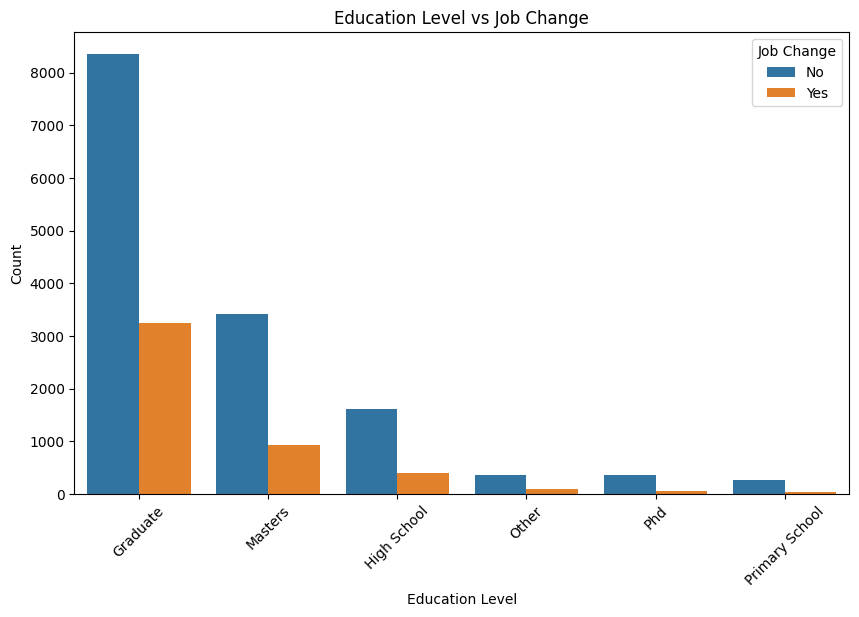

In [14]:
# 2. Education Level vs Job Change
plt.figure(figsize=(10, 6))
sns.countplot(x='education_level', hue='target', data=eda)
plt.title('Education Level vs Job Change')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Job Change', loc='upper right', labels=['No', 'Yes'])
plt.show()

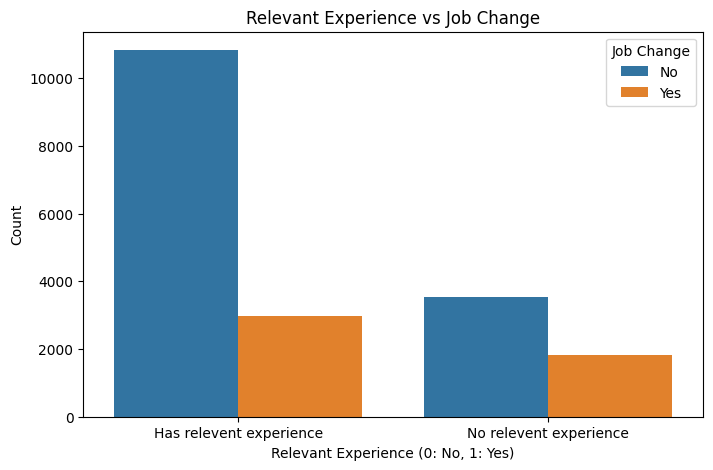

In [15]:
# 3. Relevant Experience vs Job Change
plt.figure(figsize=(8, 5))
sns.countplot(x='relevent_experience', hue='target', data=eda)
plt.title('Relevant Experience vs Job Change')
plt.xlabel('Relevant Experience (0: No, 1: Yes)')
plt.ylabel('Count')
plt.legend(title='Job Change', loc='upper right', labels=['No', 'Yes'])
plt.show()

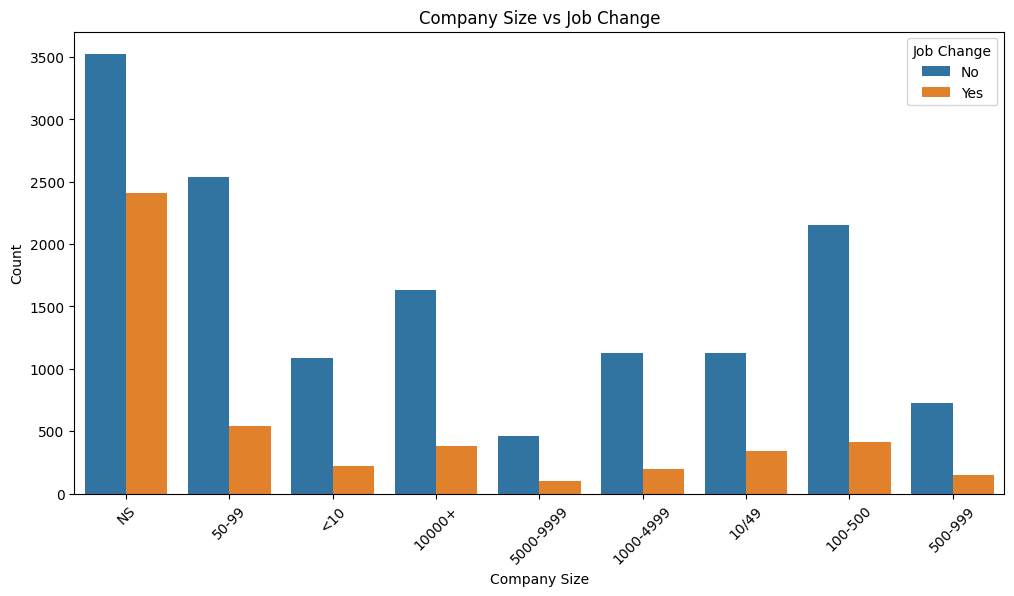

In [16]:
# 4. Company Size vs Job Change
plt.figure(figsize=(12, 6))
sns.countplot(x='company_size', hue='target', data=eda)
plt.title('Company Size vs Job Change')
plt.xlabel('Company Size')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Job Change', loc='upper right', labels=['No', 'Yes'])
plt.show()


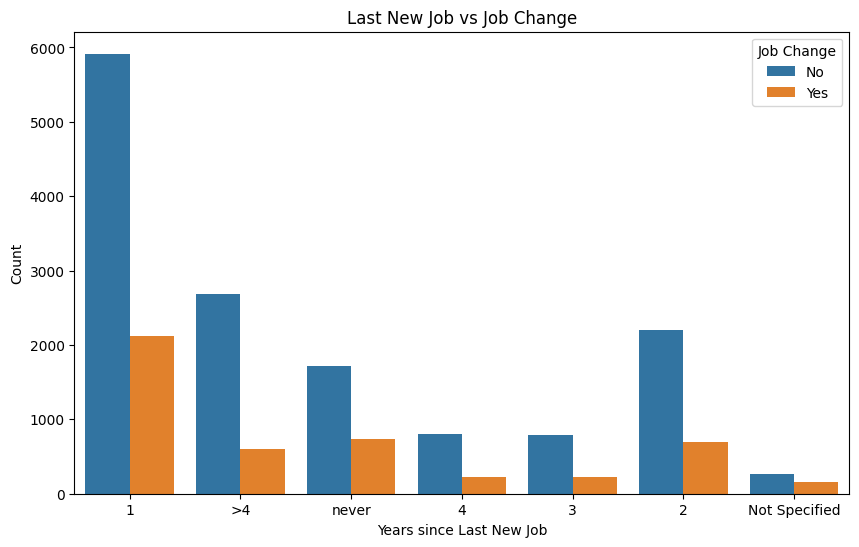

In [17]:
# 5. Last New Job vs Job Change
plt.figure(figsize=(10, 6))
sns.countplot(x='last_new_job', hue='target', data=eda)
plt.title('Last New Job vs Job Change')
plt.xlabel('Years since Last New Job')
plt.ylabel('Count')
plt.legend(title='Job Change', loc='upper right', labels=['No', 'Yes'])
plt.show()

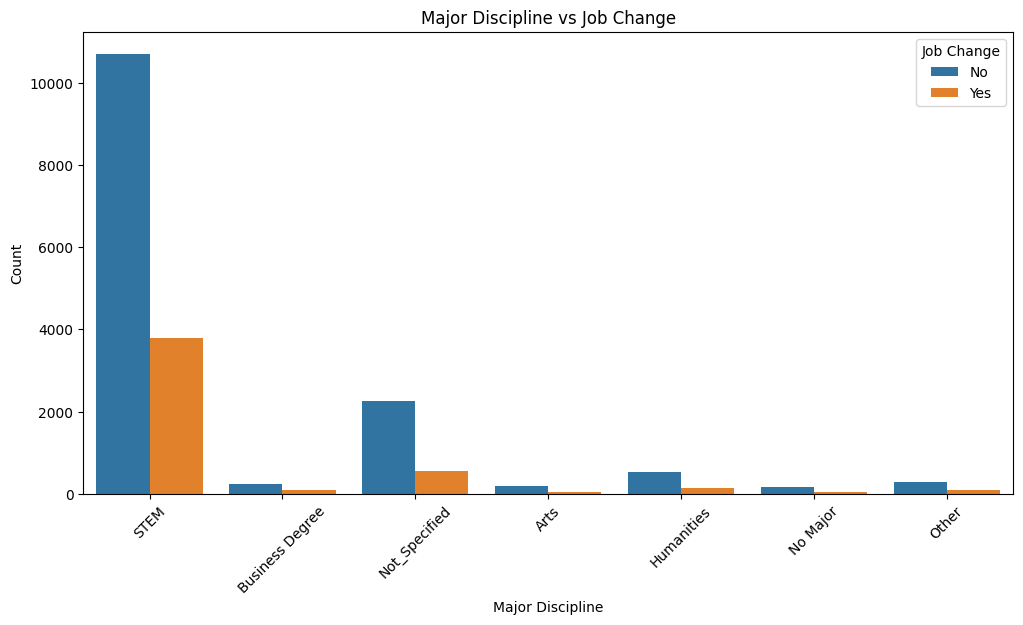

In [18]:
# 6. Major Discipline vs Job Change
plt.figure(figsize=(12, 6))
sns.countplot(x='major_discipline', hue='target', data=eda)
plt.title('Major Discipline vs Job Change')
plt.xlabel('Major Discipline')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Job Change', loc='upper right', labels=['No', 'Yes'])
plt.show()

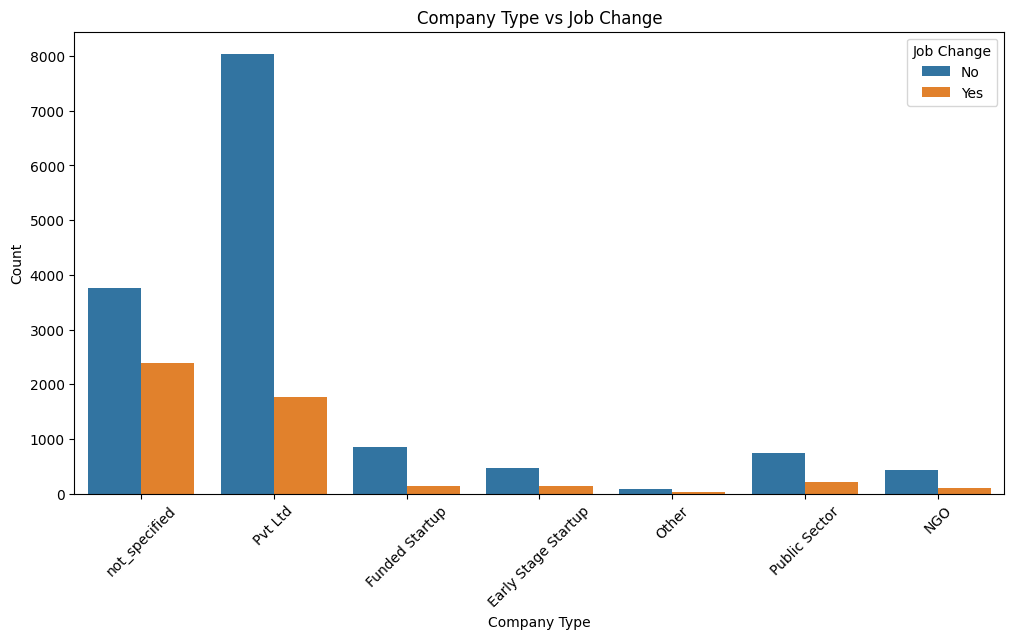

In [19]:
# 7. Company Type vs Job Change
plt.figure(figsize=(12, 6))
sns.countplot(x='company_type', hue='target', data=eda)
plt.title('Company Type vs Job Change')
plt.xlabel('Company Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Job Change', loc='upper right', labels=['No', 'Yes'])
plt.show()



In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# Function to convert experience and last_new_job to numeric
def convert_to_numeric(value):
    if isinstance(value, str):
        if value == '>20':
            return 21  # Assigning a value greater than 20
        elif value == '<1':
            return 0  # Assigning a value for less than 1 year
        elif value == 'never':
            return 0  # Assigning a value for never having a last new job
        elif value.isdigit():
            return int(value)  # Convert string digits to int
    return np.nan  # Return NaN for any other cases

# Apply conversion function to relevant columns
eda['experience'] = eda['experience'].apply(convert_to_numeric)
eda['last_new_job'] = eda['last_new_job'].apply(convert_to_numeric)

# Function to detect outliers using IQR method and Z-score method
def detect_outliers(EDA, feature):
    # IQR Method
    Q1 = eda[feature].quantile(0.25)
    Q3 = eda[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers using IQR
    outliers_iqr = eda[(eda[feature] < lower_bound) | (eda[feature] > upper_bound)]
    
    # Z-Score Method
    z_scores = np.abs(stats.zscore(eda[feature].dropna()))
    
    # Create a boolean mask for the original DataFrame's index
    mask = np.zeros(len(eda), dtype=bool)
    mask[eda[feature].dropna().index] = (z_scores > 3)
    
    outliers_z = eda[mask]
    
    return outliers_iqr, outliers_z

  

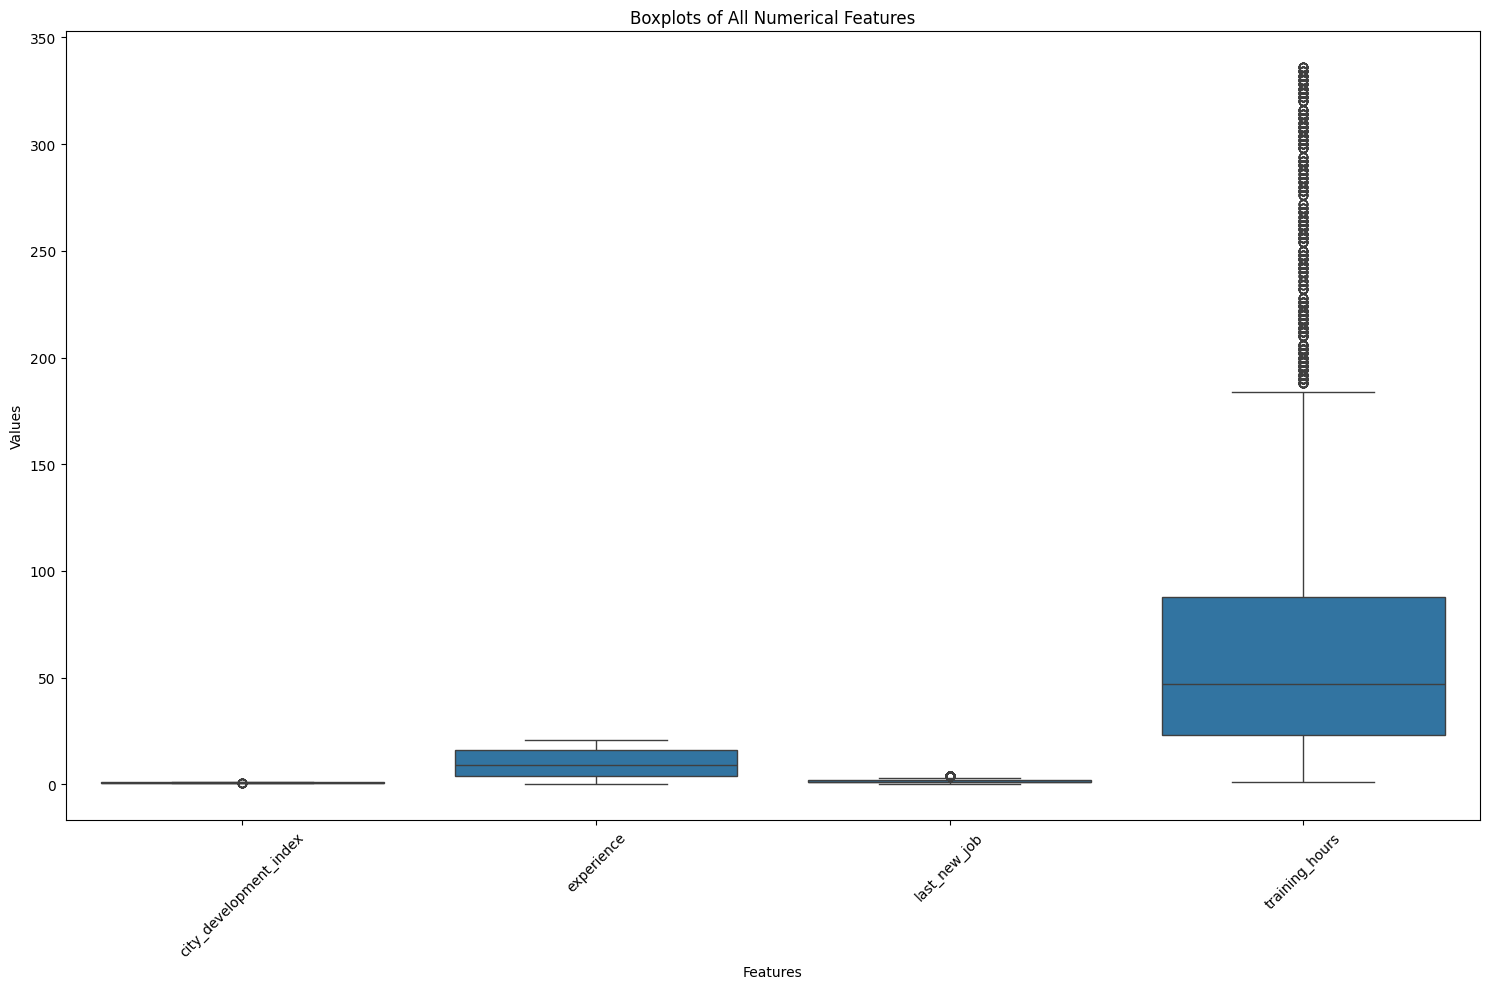

In [21]:
# Remove the 'enrollee_id' and 'target' columns
x = eda.drop(['enrollee_id', 'target'],axis=1)

# Select numerical features
numerical_features = x.select_dtypes(include=['float64', 'int64']).columns

# Melt the DataFrame to long format for seaborn
melted_df = x[numerical_features].melt(var_name='Feature', value_name='Values')

# Create a boxplot for all numerical features in a single graph
plt.figure(figsize=(15, 10))
sns.boxplot(x='Feature', y='Values', data=melted_df)
plt.title('Boxplots of All Numerical Features')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.ylabel('Values')
plt.xlabel('Features')

plt.tight_layout()
plt.show()

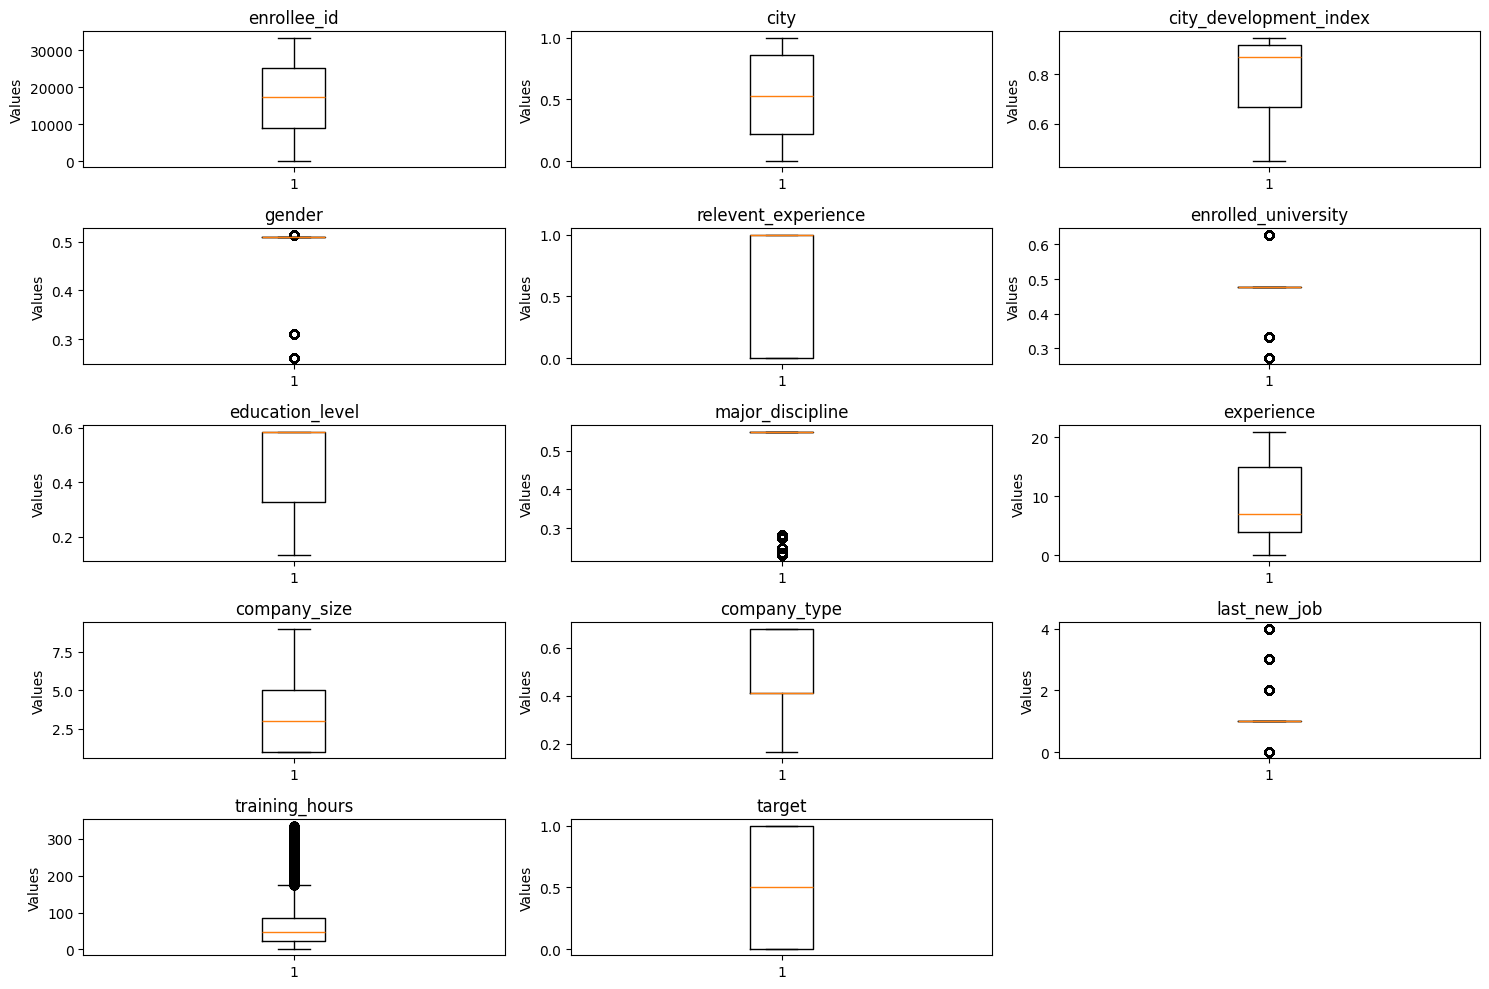

In [22]:
eda = pre.handle_imbalance()
eda = pre.encode_features()
# creating box plot for all the feature 
# Select numerical features
numerical_features = eda.select_dtypes(include=['float64', 'int64']).columns

# Create boxplots for each numerical feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(len(numerical_features)//3 + 1, 3, i + 1)
    plt.boxplot(eda[feature].dropna())  # Drop NaN values for plotting
    plt.title(feature)
    plt.ylabel('Values')

plt.tight_layout()
plt.show()

In [23]:
## Insides of the data 

# Preprocessing the data

In [24]:
# function in the top 

In [25]:
df.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [27]:
pre_pross = Preprocessing(df)
df=pre_pross.preprocess()

Outliers have been capped.


/tmp/ipykernel_9535/1595450844.py:57: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df["last_new_job"]=self.df["last_new_job"].replace(i,j)
/tmp/ipykernel_9535/1595450844.py:68: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df["experience"]=self.df["experience"].replace(i,j)


In [28]:
df.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [29]:
df

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,0.525281,0.920000,0.511016,1,0.477886,0.586342,0.548767,21,1,0.681263,2.0,36.0,1.0
1,29725,0.309524,0.776000,0.511016,0,0.477886,0.586342,0.548767,15,4,0.410194,4.5,47.0,0.0
2,11561,0.857658,0.624000,0.509899,0,0.628494,0.586342,0.548767,5,1,0.681263,0.5,83.0,0.0
3,33241,0.500000,0.789000,0.509899,0,0.334177,0.586342,0.276276,0,1,0.410194,0.5,52.0,1.0
4,666,0.434783,0.767000,0.511016,1,0.477886,0.326386,0.548767,21,4,0.163265,4.5,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28757,21952,0.857658,0.652873,0.511016,1,0.477886,0.586342,0.548767,8,5,0.410194,4.0,17.0,1.0
28758,2198,0.857658,0.764499,0.511016,1,0.477886,0.586342,0.548767,14,4,0.410194,4.5,68.0,1.0
28759,28092,0.525281,0.920000,0.511016,1,0.477886,0.586342,0.548767,21,1,0.681263,2.0,101.0,1.0
28760,5555,0.857658,0.699495,0.509899,1,0.477886,0.326386,0.548767,6,1,0.410194,2.0,147.0,1.0


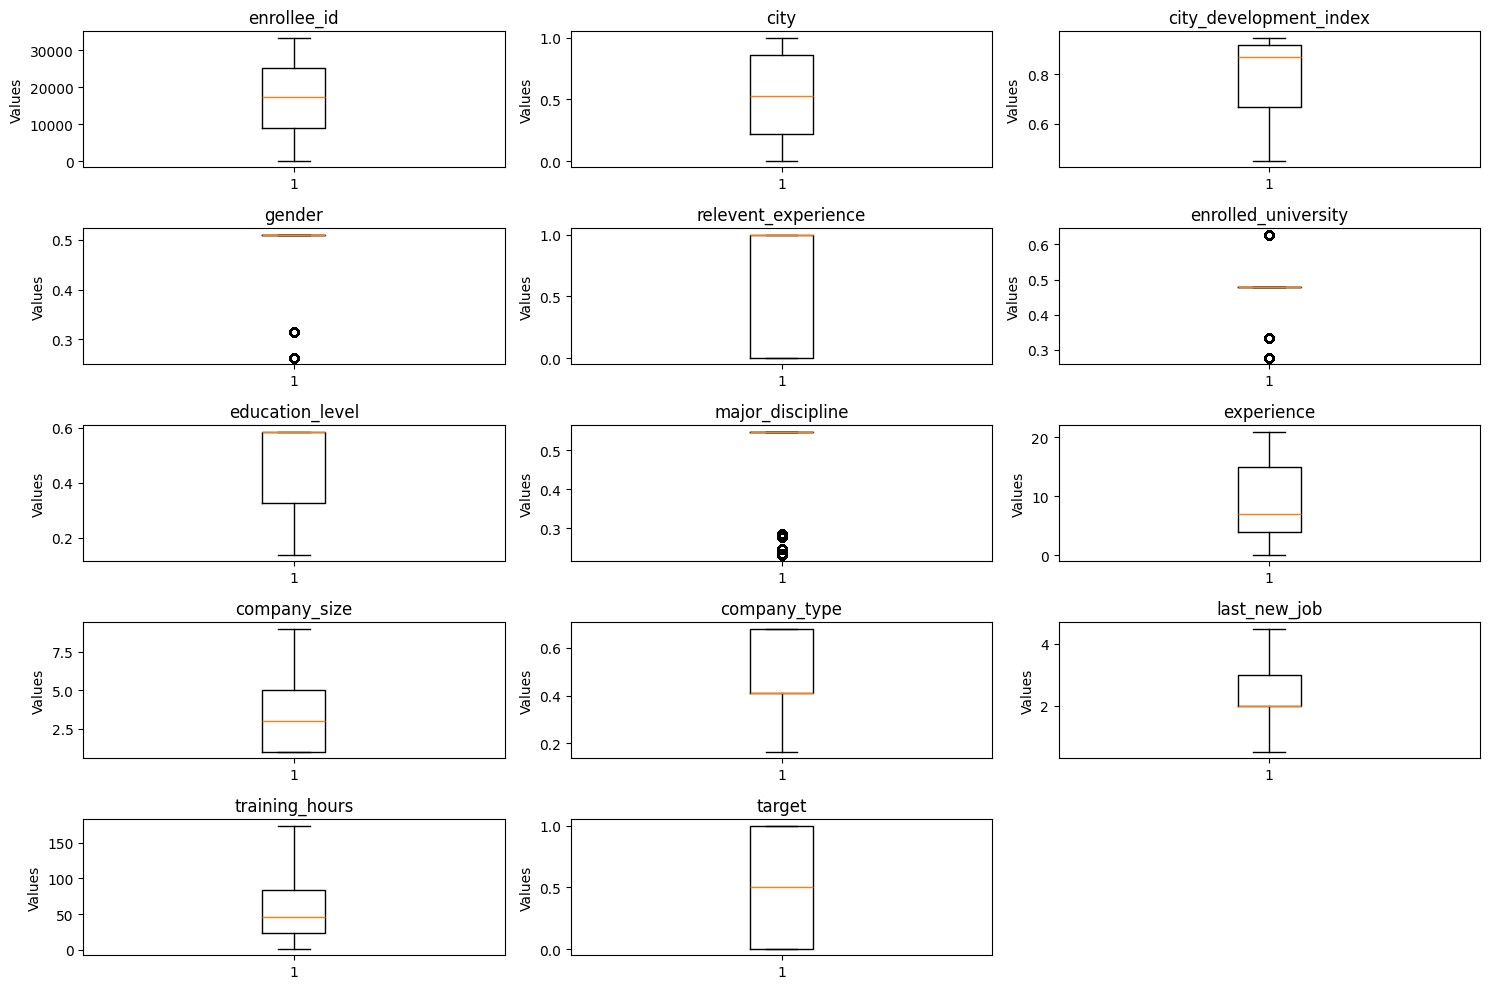

In [30]:

# creating box plot for all the feature 
# Select numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

# Create boxplots for each numerical feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(len(numerical_features)//3 + 1, 3, i + 1)
    plt.boxplot(df[feature].dropna())  # Drop NaN values for plotting
    plt.title(feature)
    plt.ylabel('Values')

plt.tight_layout()
plt.show()

In [31]:
df["target"].value_counts()

target
1.0    14381
0.0    14381
Name: count, dtype: int64

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28762 entries, 0 to 28761
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             28762 non-null  int64  
 1   city                    28762 non-null  float64
 2   city_development_index  28762 non-null  float64
 3   gender                  28762 non-null  float64
 4   relevent_experience     28762 non-null  int64  
 5   enrolled_university     28762 non-null  float64
 6   education_level         28762 non-null  float64
 7   major_discipline        28762 non-null  float64
 8   experience              28762 non-null  int64  
 9   company_size            28762 non-null  int64  
 10  company_type            28762 non-null  float64
 11  last_new_job            28762 non-null  float64
 12  training_hours          28762 non-null  float64
 13  target                  28762 non-null  float64
dtypes: float64(10), int64(4)
memory usage:

In [33]:
X = df.drop("target",axis=1)
y = df["target"]


In [34]:
scaler = StandardScaler()
X =scaler.fit_transform(X)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
from sklearn.preprocessing import*
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,precision_score,recall_score,f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

def evaluate_models(df):

    #creating dependent and independent features
    X = df.drop("target",axis=1)
    y = df["target"]

    # trian test split 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define models
    models = {
        "LogisticRegression": LogisticRegression(),
        "RandomForestClassifier": RandomForestClassifier(random_state=24),
        "XGBoost": XGBClassifier(random_state=24),
        "LightGBM": LGBMClassifier(verbosity = -1)
    }

    # Initialize a list to store metrics
    metrics_list = []

    # Iterate through models
    for model_name, model in models.items():
        model.fit(X_train, y_train)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Collect metrics for training
        metrics_train = {
            'Model': model_name,
            'Accuracy_Train': accuracy_score(y_train, y_train_pred),
            'Precision_Train': precision_score(y_train, y_train_pred, average='weighted', zero_division=0),
            'Recall_Train': recall_score(y_train, y_train_pred, average='weighted', zero_division=0),
            'F1_Score_Train': f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
        }

        # Check if the model supports ROC AUC score calculation
        if hasattr(model, "predict_proba"):
            metrics_train['AUC_ROC_Train'] = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
        else:
            warnings.warn(f"{model_name} does not support probability predictions for ROC AUC.")

        # Collect metrics for testing
        metrics_test = {
            'Accuracy_Test': accuracy_score(y_test, y_test_pred),
            'Precision_Test': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
            'Recall_Test': recall_score(y_test, y_test_pred, average='weighted', zero_division=0),
            'F1_Score_Test': f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
        }

        # Check if the model supports ROC AUC score calculation
        if hasattr(model, "predict_proba"):
            metrics_test['AUC_ROC_Test'] = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        else:
            warnings.warn(f"{model_name} does not support probability predictions for ROC AUC.")

        # Combine train and test metrics into one dictionary
        combined_metrics = {**metrics_train, **metrics_test}

        # Append to the list
        metrics_list.append(combined_metrics)

    # Create a DataFrame from the list of metrics
    metrics_df = pd.DataFrame(metrics_list)

    return metrics_df

# Example usage:
# Assuming X_train, y_train, X_test, and y_test are already defined.
# metrics_df = evaluate_models(X_train, y_train, X_test, y_test)
# print(metrics_df)

In [37]:
metrics_df = evaluate_models(df)
metrics_df

,Model,Accuracy_Train,Precision_Train,Recall_Train,F1_Score_Train,AUC_ROC_Train,Accuracy_Test,Precision_Test,Recall_Test,F1_Score_Test,AUC_ROC_Test
0,LogisticRegression,0.829154,0.829193,0.829154,0.829149,0.876273,0.824787,0.824911,0.824787,0.824771,0.875168
1,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,0.852946,0.852996,0.852946,0.852941,0.921869
2,XGBoost,0.912339,0.912342,0.912339,0.912338,0.975327,0.853642,0.853675,0.853642,0.853638,0.922311
3,LightGBM,0.874614,0.874748,0.874614,0.874603,0.949783,0.854337,0.854626,0.854337,0.854308,0.923879


# Hyperparameter Tuning

## Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators":[200,400,600],
    "max_depth":[1,2,3,4],
    "min_samples_split":[2,4],
    "min_samples_leaf":[2,4],
}
# random forest model
rd = RandomForestClassifier()
# grid search cv model
grid_search = GridSearchCV(estimator=rd,param_grid=param_grid,cv=10,scoring="accuracy")
grid_search.fit(X_train,y_train) # train the model

print(grid_search.best_estimator_) # print the best estimator
print(grid_search.best_params_) # print the best parameters
print(grid_search.best_score_) # print the best score



In [ ]:
import optuna

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Create and train the Random Forest model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    model.fit(X_train, y_train)

    # Make predictions and evaluate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and their corresponding accuracy
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

#best parameter

first 1:

    RandomForestClassifier(max_depth=4, min_samples_leaf=4, min_samples_split=4,
                          n_estimators=400)
    {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 400}
    0.8358032235511971

  pass2:

    RandomForestClassifier(max_depth=4, min_samples_leaf=4, min_samples_split=4,
                          n_estimators=700)
    {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 700}
    0.8359771554900517

  pass3:

    Best hyperparameters: {'n_estimators': 190, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 1}
    Best accuracy: 0.8555536241960716

# XGBoost

In [ ]:
# Hyperparameter Tuning for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [300,400,500],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# XGBoost model
xgb = XGBClassifier()

# Grid search CV model for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring="accuracy", n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)  # Train the model

print("Best XGBoost Estimator:", grid_search_xgb.best_estimator_)
print("Best XGBoost Parameters:", grid_search_xgb.best_params_)
print("Best XGBoost Score:", grid_search_xgb.best_score_)

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

    # Create and train the XGBoost model
    model = XGBClassifier(
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        n_estimators=100,
        random_state=42
    )

    model.fit(X_train, y_train)

    # Make predictions and evaluate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and their corresponding accuracy
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

# best param

pass1:

    Best XGBoost Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
    Best XGBoost Score: 0.8556215553541117

pass2:

    Best XGBoost Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}
    Best XGBoost Score: 0.8554912528227099

pass3:
    
    Best hyperparameters: {'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.9048628638435, 'colsample_bytree': 0.5853316948275066}
    Best accuracy: 0.8557274465496263

# LogisticRegression

In [ ]:
from sklearn.model_selection import GridSearchCV


# Hyperparameter Tuning for Logistic Regression
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1,0.5,1,5,10],
    'solver': ['lbfgs', 'liblinear','newton-cg', 'newton-cholesky']
}

# Logistic Regression model
lr = LogisticRegression(max_iter=1000)

# Grid search CV model for Logistic Regression
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5, scoring="accuracy", n_jobs=-1)
grid_search_lr.fit(X_train, y_train)  # Train the model

print("Best Logistic Regression Estimator:", grid_search_lr.best_estimator_)
print("Best Logistic Regression Parameters:", grid_search_lr.best_params_)
print("Best Logistic Regression Score:", grid_search_lr.best_score_)

## best paramater 

pass1:

        Best Logistic Regression Estimator: LogisticRegression(C=0.01, max_iter=1000, penalty='l1', solver='liblinear')
        Best Logistic Regression Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
        Best Logistic Regression Score: 0.8295448970383307

pass2:

        Best Logistic Regression Estimator: LogisticRegression(C=0.5, max_iter=1000)
        Best Logistic Regression Parameters: {'C': 0.5, 'penalty': 'l2', 'solver': 'lbfgs'}
        Best Logistic Regression Score: 0.8291101994814157


# LightGBM

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import optuna
from sklearn.metrics import accuracy_score

# Load dataset (for example, using the Iris dataset)
X, y = load_iris(return_X_y=True)

# Check unique classes in target variable
print("Unique classes in target variable:", np.unique(y))

# Stratified split to maintain class distribution
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the objective function for Optuna
def objective(trial):
    param = {
        'objective': 'multiclass',  # Use 'binary' for binary classification
        'metric': 'multi_logloss',  # Use appropriate metric for multiclass
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
    }

    # Train the model
    model = lgb.LGBMClassifier(**param)
    model.fit(X_train, y_train)

    # Validate the model
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and their corresponding accuracy
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [20, 40, 100]
}

# Create a LightGBM classifier
lgbm = lgb.LGBMClassifier(verbosity = -1)

# Set up GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid,
                           scoring='accuracy', cv=5, n_jobs=-1)

# Fit GridSearchCV to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best parameters from GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

# Use the best estimator to make predictions on validation set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)

# Calculate accuracy on validation set
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)


## best paramater 

pass1:

        Best hyperparameters: {'num_leaves': 126, 'learning_rate': 0.2751701213598749, 'max_depth': 35, 'min_data_in_leaf': 10, 'lambda_l1': 7.511988202098125, 'lambda_l2': 7.412844949836307, 'bagging_fraction': 0.5954374457991968, 'feature_fraction': 0.8296990927940129}
        Best accuracy: 0.9666666666666667

pass2:

        Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 20, 'num_leaves': 31}
        Validation Accuracy: 0.9666666666666667

# Hypermater tuning score

/home/codespace/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import optuna
from sklearn.preprocessing import StandardScaler

def hyperparam_models(data, target_column):
    # Split the DataFrame into features and target variable
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Split data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define models and their hyperparameters for GridSearchCV
    models = {
        "LogisticRegression": {
            "model": LogisticRegression(),
            "params": {
                'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10],
                'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']
            },
            "use_optuna": False
        },
        "RandomForestClassifier": {
            "model": RandomForestClassifier(random_state=24),
            "params": {
                "max_depth": [1, 2, 3, 4],
                "min_samples_split": [2, 4],
                "min_samples_leaf": [2, 4],
            },
            "use_optuna": False
        },
        "XGBoost": {
            "model": XGBClassifier(random_state=24),
            "params": None,
            "use_optuna": True
        },
        "LightGBM": {
            "model": LGBMClassifier(verbosity=-1),
            "params": None,
            "use_optuna": True
        }
    }

    # Initialize lists to store metrics and best parameters
    gridsearch_metrics_list = []
    optuna_metrics_list = []
    best_params_list = []

    # Iterate through models
    for model_name, model_info in models.items():
        model = model_info["model"]
        
        if model_info["use_optuna"]:
            # Define the objective function for Optuna
            def objective(trial):
                if model_name == "XGBoost":
                    param = {
                        'max_depth': trial.suggest_int('max_depth', 1, 10),
                        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
                    }
                    model.set_params(**param)
                elif model_name == "LightGBM":
                    param = {
                        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
                        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                        'n_estimators': trial.suggest_int('n_estimators', 50, 200)
                    }
                    model.set_params(**param)

                # Fit the model and return accuracy as the objective value
                model.fit(X_train, y_train)
                return accuracy_score(y_test, model.predict(X_test))

            # Create an Optuna study and optimize the objective function
            study = optuna.create_study(direction='maximize')
            study.optimize(objective, n_trials=100)

            # Get best parameters from Optuna study
            best_params = study.best_params
            model.set_params(**best_params)

            # Fit the final model with best parameters on training data
            model.fit(X_train, y_train)

            # Predictions on train and test data
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # Collect metrics for training and testing for Optuna
            metrics = {
                'Model': model_name,
                'Accuracy_Train': accuracy_score(y_train, y_train_pred),
                'Precision_Train': precision_score(y_train, y_train_pred, average='weighted', zero_division=0),
                'Recall_Train': recall_score(y_train, y_train_pred, average='weighted', zero_division=0),
                'F1_Score_Train': f1_score(y_train, y_train_pred, average='weighted', zero_division=0),
                'Accuracy_Test': accuracy_score(y_test, y_test_pred),
                'Precision_Test': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
                'Recall_Test': recall_score(y_test, y_test_pred, average='weighted', zero_division=0),
                'F1_Score_Test': f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
            }

            # Append metrics and best params to the lists
            optuna_metrics_list.append(metrics)
            best_params_list.append({'Model': model_name, 'Best_Params': best_params})

        else:
            # Use GridSearchCV for Logistic Regression and Random Forest
            grid_search = GridSearchCV(estimator=model,
                                       param_grid=model_info["params"],
                                       scoring='accuracy',
                                       cv=5,
                                       n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_params = grid_search.best_params_
            model.set_params(**best_params)

            # Fit the final model with best parameters on training data
            model.fit(X_train, y_train)

            # Predictions on train and test data
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # Collect metrics for training and testing for GridSearchCV
            metrics = {
                'Model': model_name,
                'Accuracy_Train': accuracy_score(y_train, y_train_pred),
                'Precision_Train': precision_score(y_train, y_train_pred, average='weighted', zero_division=0),
                'Recall_Train': recall_score(y_train, y_train_pred, average='weighted', zero_division=0),
                'F1_Score_Train': f1_score(y_train, y_train_pred, average='weighted', zero_division=0),
                'Accuracy_Test': accuracy_score(y_test, y_test_pred),
                'Precision_Test': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
                'Recall_Test': recall_score(y_test, y_test_pred, average='weighted', zero_division=0),
                'F1_Score_Test': f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
            }

            # Append metrics and best params to the lists
            gridsearch_metrics_list.append(metrics)
            best_params_list.append({'Model': model_name, 'Best_Params': best_params})

    # Create DataFrames from the lists of metrics and parameters
    gridsearch_metrics_df = pd.DataFrame(gridsearch_metrics_list)
    optuna_metrics_df = pd.DataFrame(optuna_metrics_list)
    
    best_params_df = pd.DataFrame(best_params_list)

    return gridsearch_metrics_df, optuna_metrics_df, best_params_df

# Example usage:
# Assuming data is a pandas DataFrame with a target column named 'target'.
# metrics_gridsearch_df, metrics_optuna_df ,best_parameters_df = hyperparam_models(data=data_frame_with_target_column,'target')
# print("GridSearchCV Results:\n", metrics_gridsearch_df)
# print("Optuna Results:\n", metrics_optuna_df)
# print("Best Parameters:\n", best_parameters_df)

In [40]:
a,b,c=hyperparam_models(df,"target")

[I 2024-10-23 19:01:31,517] A new study created in memory with name: no-name-58d2c331-53bb-4345-a597-8f1bb205bb83
[I 2024-10-23 19:01:31,696] Trial 0 finished with value: 0.849643664175213 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.5841911058709688, 'colsample_bytree': 0.6387966563538179}. Best is trial 0 with value: 0.849643664175213.
[I 2024-10-23 19:01:31,827] Trial 1 finished with value: 0.8461672171041196 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.5227996317582251, 'colsample_bytree': 0.6940337547467506}. Best is trial 0 with value: 0.849643664175213.
[I 2024-10-23 19:01:32,146] Trial 2 finished with value: 0.8402572570832609 and parameters: {'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.6080178319482483, 'colsample_bytree': 0.9697190263236295}. Best is trial 0 with value: 0.849643664175213.
[I 2024-10-23 19:01:32,278] Trial 3 finished with value: 0.8486007300538849 and parameters: {'max_depth': 3, 'min_child_weight

# Greadsearchcv

In [41]:
a

,Model,Accuracy_Train,Precision_Train,Recall_Train,F1_Score_Train,Accuracy_Test,Precision_Test,Recall_Test,F1_Score_Test
0,LogisticRegression,0.829197,0.829237,0.829197,0.829192,0.824787,0.824911,0.824787,0.824771
1,RandomForestClassifier,0.837151,0.837716,0.837151,0.837082,0.835912,0.836734,0.835912,0.835812


# Optuna

In [42]:
b

,Model,Accuracy_Train,Precision_Train,Recall_Train,F1_Score_Train,Accuracy_Test,Precision_Test,Recall_Test,F1_Score_Test
0,XGBoost,0.904516,0.904530,0.904516,0.904515,0.856075,0.856078,0.856075,0.856075
1,LightGBM,0.923595,0.923606,0.923595,0.923595,0.856249,0.856268,0.856249,0.856247


# Hyperparamater tuning score dataframe

In [43]:
h_para_score = pd.concat([a,b],axis=0)

In [44]:
h_para_score

,Model,Accuracy_Train,Precision_Train,Recall_Train,F1_Score_Train,Accuracy_Test,Precision_Test,Recall_Test,F1_Score_Test
0,LogisticRegression,0.829197,0.829237,0.829197,0.829192,0.824787,0.824911,0.824787,0.824771
1,RandomForestClassifier,0.837151,0.837716,0.837151,0.837082,0.835912,0.836734,0.835912,0.835812
0,XGBoost,0.904516,0.904530,0.904516,0.904515,0.856075,0.856078,0.856075,0.856075
1,LightGBM,0.923595,0.923606,0.923595,0.923595,0.856249,0.856268,0.856249,0.856247


# Best paramater 

In [45]:
for i in range(len(c.Model)):
    print(f"{c["Model"][i]}: {c["Best_Params"][i]}")

LogisticRegression: {'C': 0.5, 'solver': 'newton-cg'}
RandomForestClassifier: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}
XGBoost: {'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.8212906388666094, 'colsample_bytree': 0.6552955912082187}
LightGBM: {'num_leaves': 66, 'learning_rate': 0.09219174413525645, 'n_estimators': 183}


In [46]:
c["Best_Params"][3]

{'num_leaves': 66, 'learning_rate': 0.09219174413525645, 'n_estimators': 183}

# Creating the best model with the best paramater 


In [47]:
X_train

array([[-1.58746657,  1.36816144, -1.3849674 , ..., -1.47503488,
        -0.37106659, -1.17569042],
       [-0.2423881 , -1.21402786,  0.93594001, ..., -0.5540506 ,
        -0.37106659,  1.56311596],
       [ 0.21033592, -1.19074902,  0.40213131, ...,  1.11828962,
         1.65256201,  0.38628509],
       ...,
       [-1.11316431,  1.36816144, -1.3849674 , ...,  1.11828962,
        -1.58524375, -0.94032425],
       [-1.44406555, -1.18895488,  0.48723125, ..., -0.5540506 ,
         1.65256201, -0.2128288 ],
       [ 1.44186676, -0.35233331,  0.22971106, ...,  1.11828962,
        -1.58524375,  1.41333749]])

In [50]:
import joblib
params=c["Best_Params"][3]

model = LGBMClassifier(**params)
model.fit(X_train, y_train)

# Save the model using joblib (pickle)
joblib.dump(model, 'lightgbm_model.pkl')

print("Model saved as lightgbm_model.pkl")

Model saved as lightgbm_model.pkl


# test based classification 

Epoch [1/78], Loss: 0.6940
Epoch [2/78], Loss: 0.6931
Epoch [3/78], Loss: 0.6920
Epoch [4/78], Loss: 0.6914
Epoch [5/78], Loss: 0.6903
Epoch [6/78], Loss: 0.6894
Epoch [7/78], Loss: 0.6880
Epoch [8/78], Loss: 0.6869
Epoch [9/78], Loss: 0.6852
Epoch [10/78], Loss: 0.6836
Epoch [11/78], Loss: 0.6819
Epoch [12/78], Loss: 0.6794
Epoch [13/78], Loss: 0.6771
Epoch [14/78], Loss: 0.6743
Epoch [15/78], Loss: 0.6711
Epoch [16/78], Loss: 0.6678
Epoch [17/78], Loss: 0.6644
Epoch [18/78], Loss: 0.6599
Epoch [19/78], Loss: 0.6554
Epoch [20/78], Loss: 0.6504
Epoch [21/78], Loss: 0.6452
Epoch [22/78], Loss: 0.6393
Epoch [23/78], Loss: 0.6338
Epoch [24/78], Loss: 0.6273
Epoch [25/78], Loss: 0.6205
Epoch [26/78], Loss: 0.6138
Epoch [27/78], Loss: 0.6056
Epoch [28/78], Loss: 0.5986
Epoch [29/78], Loss: 0.5903
Epoch [30/78], Loss: 0.5822
Epoch [31/78], Loss: 0.5732
Epoch [32/78], Loss: 0.5646
Epoch [33/78], Loss: 0.5566
Epoch [34/78], Loss: 0.5468
Epoch [35/78], Loss: 0.5391
Epoch [36/78], Loss: 0.5303
E

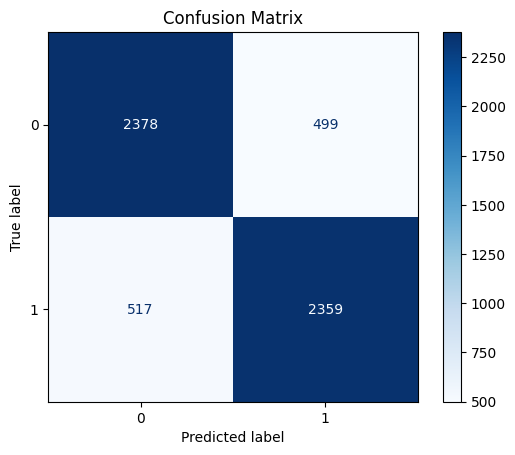

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pickle

# Load the dataset
data = pd.read_csv('aug_train.csv')

pr = Preprocessing(data)
data = pr.handle_nulls()
data = pr.handle_imbalance()

# Prepare the features by concatenating relevant columns into a single string
data['combined_features'] = (
    data['city'].fillna('') + ' ' +
    data['gender'].fillna('') + ' ' +
    data['relevent_experience'].fillna('') + ' ' +
    data['enrolled_university'].fillna('') + ' ' +
    data['education_level'].fillna('') + ' ' +
    data['major_discipline'].fillna('') + ' ' +
    data['experience'].fillna('') + ' ' +
    data['company_size'].fillna('') + ' ' +
    data['company_type'].fillna('') + ' ' +
    data['last_new_job'].fillna('') + ' ' +
    data['training_hours'].astype(str).fillna('')
)

# Define features and target variable
X = data['combined_features']
y = LabelEncoder().fit_transform(data['target'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_tfidf)
X_test_tensor = torch.FloatTensor(X_test_tfidf)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 2)  # Output layer for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleNN(input_dim=X_train_tfidf.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 78
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor)

    # Compute loss and backpropagate
    loss = criterion(outputs, y_train_tensor)
    loss.backward()

    # Update weights
    optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model's accuracy on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted_classes = torch.max(test_outputs.data, 1)

# Calculate metrics
accuracy = accuracy_score(y_test_tensor.numpy(), predicted_classes.numpy())
roc_auc = roc_auc_score(y_test_tensor.numpy(), torch.softmax(test_outputs, dim=1)[:, 1].numpy())
conf_matrix = confusion_matrix(y_test_tensor.numpy(), predicted_classes.numpy())

print(f'Accuracy: {accuracy:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')

# Display confusion matrix
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Save the model and vectorizer to disk using pickle
with open('text_model.pkl', 'wb') as model_file:
    pickle.dump(model.state_dict(), model_file)  # Save model weights

with open('vectorizer_text.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)  # Save vectorizer

# Function to classify new sentences based on combined features
def classify_features(features):
    features_tfidf = vectorizer.transform([features]).toarray()
    features_tensor = torch.FloatTensor(features_tfidf)

    with torch.no_grad():
        output = model(features_tensor)
        _, predicted_class = torch.max(output.data, 1)

    return predicted_class.item()

# Testing with profile summary

In [52]:
# Example usage:
new_features = "A motivated graduate with a STEM background seeking to enter the workforce. With 15 years of general experience, I am eager to apply my skills to a new role within a mid-sized private company. While I lack specific industry experience, my strong academic foundation and adaptability make me a valuable asset to any team."
print(f'The features are classified as: {classify_features(new_features)}')


The features are classified as: 1


# stremlet app 


In [ ]:
import pandas as pd

class Preprocessing:
    def __init__(self, df):
        self.df = df
        self.target_mean_feature=[]

    def handle_nulls(self):
        """Fill null values in specific columns."""
        self.df["enrolled_university"] = self.df["enrolled_university"].fillna("none")
        self.df["education_level"] = self.df["education_level"].fillna("Other")
        mode = self.df["experience"].mode()
        self.df["experience"] = self.df["experience"].fillna(mode[0])
        self.df["last_new_job"] = self.df["last_new_job"].fillna("Not Specified")
        self.df['major_discipline'] = self.df['major_discipline'].fillna("Not Specified")
        self.df["gender"] = self.df["gender"].fillna("Not Specified")
        self.df["company_size"] = self.df["company_size"].fillna("Not Specified")
        self.df["company_type"] = self.df["company_type"].fillna("Not Specified")

    def encode_features(self):
        """Encode categorical features with target mean."""
        features = ['gender', "enrolled_university", "major_discipline",
                    "education_level", "company_type", "city"]

        for i,feature in enumerate(features):
            self.target_mean_feature.append(self.df.groupby(feature)['target'].mean())
            self.df[feature] = self.df[feature].map(target_mean_feature[i])

        """Map relevant experience to binary values."""
        self.df["relevent_experience"] = self.df["relevent_experience"].map({
            'Has relevent experience': 1,
            'No relevent experience': 0
        })

        """Map company size categories to numerical values."""
        size_mapping = {
            'Not Specified': 1,
            '<10': 2,
            '10/49': 3,
            '50-99': 4,
            '100-500': 5,
            '500-999': 6,
            '1000-4999': 7,
            '5000-9999': 8,
            '10000+': 9
        }

        self.df["company_size"] = self.df["company_size"].replace(size_mapping)

        """Map last new job categories to numerical values."""
        last_new_job_mapping = {
            'Not Specified': 0,
            '<1': 1,
            '1': 2,
            '2': 3,
            '3': 4,
            '4': 5,
            '5': 6,
            '6': 7,
            '7': 8,
            '8': 9,
            '9': 10,
            '10': 11,
            '11': 12,
            '12': 13,
            '13': 14,
            '14': 15,
            '15': 16,
            '16': 17,
            '17': 18,
            '18': 19,
            '19': 20,
            '>20': 21
        }

        unique_jobs = sorted(self.df["last_new_job"].unique().tolist())

        # Map last new job based on unique values
        for i in unique_jobs:
            if i in last_new_job_mapping:
                self.df["last_new_job"] = self.df["last_new_job"].replace(i, last_new_job_mapping[i])

        """Map experience categories to numerical values."""
        experience_mapping = {
            '>20': 21,
            '<1': 0,
            '1': 1,
            '2': 2,
            '3': 3,
            '4': 4,
            '5': 5,
            '6': 6,
            '7': 7,
            '8': 8,
            '9': 9,
            '10': 10,
            '11': 11,
            '12': 12,
            '13': 13,
            '14': 14,
            '15': 15,
            '16': 16,
            '17': 17,
            '18': 18,
            '19': 19,
            '20': 20
        }

        self.df["experience"] = self.df["experience"].map(experience_mapping)

    def preprocess(self):
        """Run all preprocessing steps."""
        self.handle_nulls()
        self.encode_features()


# Example usage:
# df = pd.read_csv('your_data.csv')
# preprocessor = Preprocessing(df)
# preprocessor.preprocess()
# processed_df = preprocessor.df

In [ ]:
import pandas as pd

class Preprocessing:
    def __init__(self, df):
        self.df = df
        self.target_mean_feature=[]

    def handle_nulls(self):
        """Fill null values in specific columns."""
        self.df["enrolled_university"] = self.df["enrolled_university"].fillna("none")
        self.df["education_level"] = self.df["education_level"].fillna("Other")
        mode = self.df["experience"].mode()
        self.df["experience"] = self.df["experience"].fillna(mode[0])
        self.df["last_new_job"] = self.df["last_new_job"].fillna("Not Specified")
        self.df['major_discipline'] = self.df['major_discipline'].fillna("Not Specified")
        self.df["gender"] = self.df["gender"].fillna("Not Specified")
        self.df["company_size"] = self.df["company_size"].fillna("Not Specified")
        self.df["company_type"] = self.df["company_type"].fillna("Not Specified")

    def encode_features(self):
        """Encode categorical features with target mean."""
        features = ['gender', "enrolled_university", "major_discipline",
                    "education_level", "company_type", "city"]

        for i,feature in enumerate(features):
            self.target_mean_feature.append(self.df.groupby(feature)['target'].mean())
            self.df[feature] = self.df[feature].map(target_mean_feature[i])

        """Map relevant experience to binary values."""
        self.df["relevent_experience"] = self.df["relevent_experience"].map({
            'Has relevent experience': 1,
            'No relevent experience': 0
        })

        """Map company size categories to numerical values."""
        size_mapping = {
            'Not Specified': 1,
            '<10': 2,
            '10/49': 3,
            '50-99': 4,
            '100-500': 5,
            '500-999': 6,
            '1000-4999': 7,
            '5000-9999': 8,
            '10000+': 9
        }

        self.df["company_size"] = self.df["company_size"].replace(size_mapping)

        """Map last new job categories to numerical values."""
        last_new_job_mapping = {
            'Not Specified': 0,
            '<1': 1,
            '1': 2,
            '2': 3,
            '3': 4,
            '4': 5,
            '5': 6,
            '6': 7,
            '7': 8,
            '8': 9,
            '9': 10,
            '10': 11,
            '11': 12,
            '12': 13,
            '13': 14,
            '14': 15,
            '15': 16,
            '16': 17,
            '17': 18,
            '18': 19,
            '19': 20,
            '>20': 21
        }

        unique_jobs = sorted(self.df["last_new_job"].unique().tolist())

        # Map last new job based on unique values
        for i in unique_jobs:
            if i in last_new_job_mapping:
                self.df["last_new_job"] = self.df["last_new_job"].replace(i, last_new_job_mapping[i])

        """Map experience categories to numerical values."""
        experience_mapping = {
            '>20': 21,
            '<1': 0,
            '1': 1,
            '2': 2,
            '3': 3,
            '4': 4,
            '5': 5,
            '6': 6,
            '7': 7,
            '8': 8,
            '9': 9,
            '10': 10,
            '11': 11,
            '12': 12,
            '13': 13,
            '14': 14,
            '15': 15,
            '16': 16,
            '17': 17,
            '18': 18,
            '19': 19,
            '20': 20
        }

        self.df["experience"] = self.df["experience"].map(experience_mapping)

    def preprocess(self):
        """Run all preprocessing steps."""
        self.handle_nulls()
        self.encode_features()


# Example usage:
# df = pd.read_csv('your_data.csv')
# preprocessor = Preprocessing(df)
# preprocessor.preprocess()
# processed_df = preprocessor.df